In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from random import randint
from PIL import Image
from math import sqrt
from math import sin
from math import cos
from math import pi
from math import floor
from math import ceil
import operator #for sorting array of tuples
from time import time

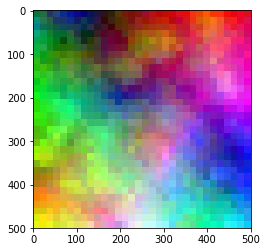

In [2]:
img = cv2.imread('som-ic2.jpg')
#convert to rgb
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure(figsize=(10,10))
plt.imshow(img_rgb)

In [3]:
dist = int(500/32)
col_arr = []
#create 2-dimensional array of colors from som-image
for x in range(0, 32):
    yArr = []
    for y in range(0, 32):
        yArr.append(img_rgb[x*dist][y*dist])
    col_arr.append(yArr)

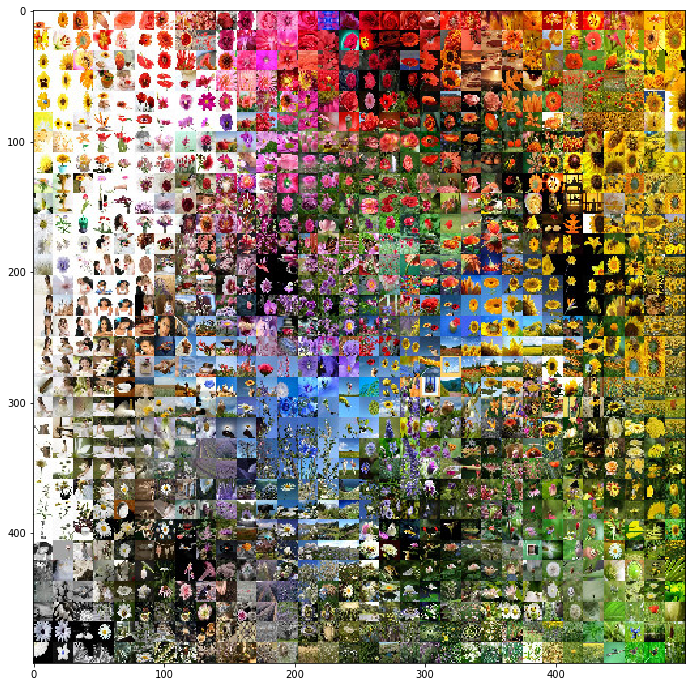

In [122]:
flowers = cv2.imread('som-flowers.jpg')
#convert to rgb
flowers_rgb = cv2.cvtColor(flowers, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(flowers_rgb)

In [26]:
def generateRandomSize(size):
    ar_width = randint(1,5)
    ar_height = randint(1,5)
    #possible aspect ratios are 1,1 1,2 1,3 .. 2,1 2,2 2,3 ... 5,1 5,2 5,3 ... 5,5
    if(ar_width < ar_height):
        width = size * (ar_width/ar_height)
        height = size
    else:
        width = size
        height = size * (ar_height/ar_width)
        
    return int(width), int(height)

In [33]:
#cut out flower images from big image
#and store into 2-dim array 'flowers_arr'

#cut out, resize flower image to random aspect ratio
#so we have images with different aspect ratios to work with
all_width = 0
all_height = 0
height, width, channels = flowers.shape
numOfImages = 32
dist = int(height/numOfImages)
flowers_arr = []
for x in range(0, 32):
    yArr = []
    for y in range(0, 32):
        y_dist, x_dist = generateRandomSize(dist) 
        yArr.append(flowers_rgb[y*dist:y*dist+y_dist, x*dist:x*dist+x_dist])
        all_width = all_width + x_dist
        all_height = all_height + y_dist
    flowers_arr.append(yArr)

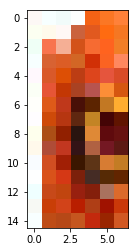

In [34]:
plt.imshow(flowers_arr[2][0])

In [35]:
print(all_width, all_height)

12249 12091


In [50]:
#cv2 img
blank = np.zeros( (500, 500, 3), np.uint8 )
#convert to pil
blank_img = Image.fromarray(blank, 'RGB')
#plt.figure(figsize=(10,10))
#plt.imshow(blank_img)

In [51]:
row_height = 0
for y in range(0,32):
    row_max_height = 0
    next_width = 0
    for x in range(0,32):
        tmp_img = flowers_arr[x][y]
        tmp_h, tmp_w, tmp_c = tmp_img.shape
        if(tmp_h > row_max_height):
            row_max_height = tmp_h
        blank[row_height:row_height+tmp_h,next_width:next_width+tmp_w] = tmp_img
        next_width = next_width + tmp_w
    row_height = row_height + row_max_height

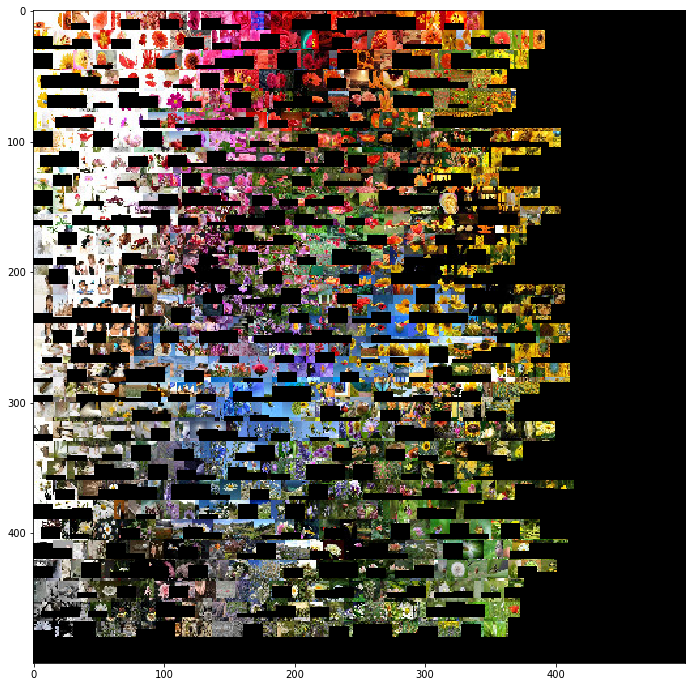

In [55]:
blank_img = Image.fromarray(blank, 'RGB')
plt.figure(figsize=(12,12))
plt.imshow(blank_img)

In [129]:
#code for r Wordle
#organise flowers with r Wordle
flower_tup_arr = []

for y in range(0,32):
    for x in range(0,32):
        tmp_flower = flowers_arr[x][y]
        #tmp_h, tmp_w, tmp_c = tmp_img.shape
        assigned = False
        flower_tup_arr.append((x*8, y*8, assigned, tmp_flower))
        

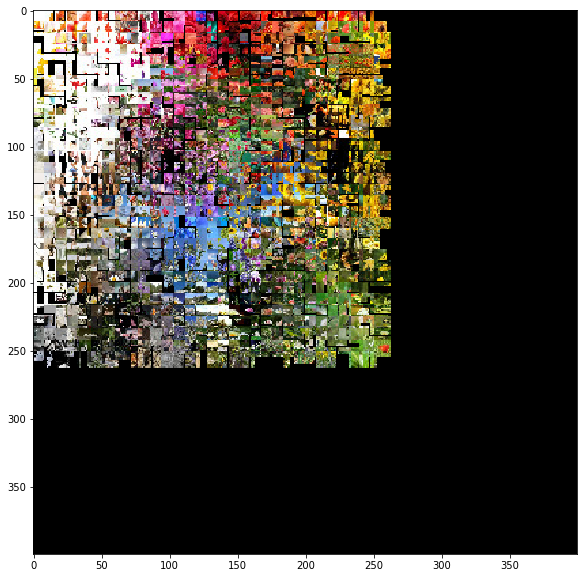

In [132]:
#previous arrangement
blank2 = np.zeros( (400, 400, 3), np.uint8 )
#convert to pil
#blank_img2 = Image.fromarray(blank2, 'RGB')

for i in range(0, len(flower_tup_arr)):
    tmp_img = flower_tup_arr[i][3]
    tmp_h, tmp_w, tmp_c = tmp_img.shape
    x = int(flower_tup_arr[i][0]) 
    y = int(flower_tup_arr[i][1])
    blank2[y : y + tmp_h, x : x + tmp_w] = tmp_img
    
blank_img2 = Image.fromarray(blank2, 'RGB')
plt.figure(figsize=(10,10))
plt.imshow(blank_img2)

In [133]:
def overlaps(tup1, tup2):
    # tuple format: (x, y, assigned, cv2_img/np_array) 
    height1, width1, c1 = tup1[3].shape
    height2, width2, c2 = tup2[3].shape
    rect1lx = tup1[0]
    rect1ly = tup1[1] 
    rect1rx = tup1[0] + width1
    rect1ry = tup1[1] + height1  
    rect2lx = tup2[0]
    rect2ly = tup2[1]
    rect2rx = tup2[0] + width2
    rect2ry = tup2[1] + height2
    
    #note: these checks depend on coordinate system layout. 
    #here it is assumed that the y-axis values increase when we go "down"
    if( rect1lx > rect2rx or rect2lx > rect1rx ):
        # rect1 lies left or right of rect2
        return False
    elif( rect1ly > rect2ry or rect2ly > rect1ry):
        # rect1 lies above or below rect2 
        return False
    else:
        return True #if none of the cases above applied, rect1 and rect2 overlap

In [134]:
def sortCircular(arr): #arr element format (x, y, assigned, img)
    centerX, centerY = 32, 32 
    arr_dist = []
    for i in range(0, len(arr)):
        x = arr[i][0]
        y = arr[i][1]
        distance = sqrt((x - centerX)*(x - centerX) + (y - centerY)*(y - centerY))
        arr_dist.append(arr[i] + (distance,))

    arr_dist.sort(key = operator.itemgetter(4))
    return arr_dist

In [135]:
#def sortLinear(arr):


In [136]:
def updatePosition(img, layouted): #img format (x, y, assigned, img, distance)
    rect = img
    #new pos on circle around old pos
    angle = 0
    angle_stepsize = pi/90
    radius = 1
    radius_stepsize = 1
    max_radius = radius_stepsize * 1000
    overlap = True
    #iterate through each angle for radius increased by radius_stepsize until max_radius
    while(overlap and radius <= max_radius): 
        while(angle < 2*pi):
            tmpRect = ()
            tmpRect = tmpRect + ( (rect[0] + radius * cos(angle)), ) #new x pos
            tmpRect = tmpRect + ( (rect[1] + radius * sin(angle)), ) #new y pos
            for a in range(2, len(rect)): 
                tmpRect = tmpRect + ( rect[a], )
            
            overlapping =  overlaps(tmpRect, layouted[0])
            for i in range(1, len(layouted)):
                #if any layouted rect still overlaps with new position of tmpRect
                overlapping = overlapping or overlaps(tmpRect, layouted[i])
            
            if(not overlapping):
                overlap = False
                return tmpRect
            
            #else: update angle
            angle = angle + angle_stepsize
            
        #reset angle
        angle = 0
        radius = radius + radius_stepsize
        
        

In [137]:
def rWordle(tup_arr): #tup_arr elements format (x, y, assigned, img, distance)
    time1 = time() #for tracking algorithm time
    #print("starting: ", time1)
    layouted = []
    
    for i in range(0, len(tup_arr)):
        overlapping = False
        for j in range(0, len(layouted)): 
            overlapping = overlaps(tup_arr[i], layouted[j])
            if (overlapping == True):
                break #no need to check all layouted if one already overlaps
        if (overlapping):
        #update position when needed
            tup_arr[i] = updatePosition(tup_arr[i], layouted)
        layouted.append(tup_arr[i])
        
    time2 = time()
    print("time for RWordle: ", time2 - time1)
    return layouted

In [138]:
layout_flowers = rWordle(flower_tup_arr)

time for RWordle:  4474.16600394249


In [139]:
#print(layout_flowers[0])

In [164]:
#cv2 img
blank3 = np.zeros( (650, 650, 3), np.uint8 )
#convert to pil
blank_img3 = Image.fromarray(blank3, 'RGB')

In [165]:
for i in range(0, len(layout_flowers)):
    tmp_img = layout_flowers[i][3]
    tmp_h, tmp_w, tmp_c = tmp_img.shape
    x = int(layout_flowers[i][0]) + 150
    y = int(layout_flowers[i][1]) + 50
    blank3[y : y + tmp_h, x : x + tmp_w] = tmp_img

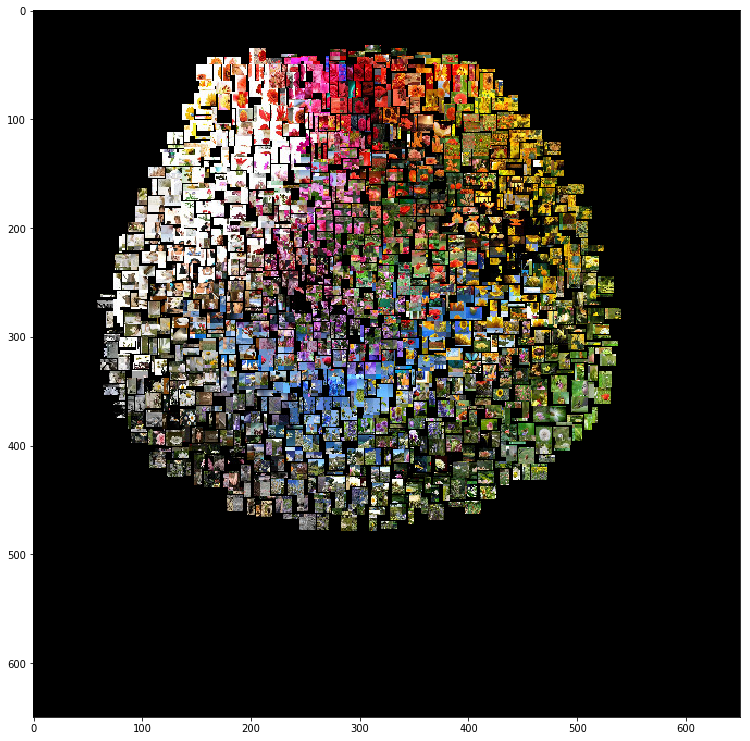

In [166]:
blank_img3 = Image.fromarray(blank3, 'RGB')
plt.figure(figsize=(13,13))
plt.imshow(blank_img3)